# Merge gpx and obs data.
Could incorporate this in code (for testing / consistency)

In [11]:
print('merge loaded')

merge loaded


In [12]:
import pandas as pd

Looks like there's a cross reference to waypoint id

Create a waypoint_year index column in gpx and observations then we can combine

In [13]:
def get_merged_dataframe():
    """Creates and returns the merged DataFrame."""

    gpx_df = pd.read_csv("../../data/processed/gpx_observations.csv")
    gpx_df["waypoint_date"] = gpx_df["name"].astype(str) + "_" + gpx_df["date"].astype(str)

    observations_df = pd.read_csv("../../data/processed/observations.csv")
    observations_df["waypoint_date"] = observations_df["garmin_waypoint_id"].astype(str) + "_" + observations_df["observation_date"].astype(str)

    df = pd.merge(observations_df, gpx_df[["lat", "lon", "ele", "cmt", "date", "waypoint_date"]], on="waypoint_date", how="left")

    return df

In [14]:
df = get_merged_dataframe()

In [15]:
df.head()

,sample_point_id,observation_date,garmin_waypoint_id,garmin_grid_ref,photo_up_id,photo_down_id,wetness_estimate,canopy_cover_estimate,species_identified,waypoint_date,lat,lon,ele,cmt,date
0,9,2019-02-01,1,TL6787633142,P2010002,P2010003,1.0,95,"['Mercurialis perennis', 'Urtica dioica', 'Sil...",1_2019-02-01,51.971350,0.442538,75.789368,NaN,2019-02-01
1,59,2019-02-01,2,TL6787433118,P2010004,P2010005,1.0,65,"['Silene dioica', 'Galium aparine', 'Glechoma ...",2_2019-02-01,51.971138,0.442500,81.909317,NaN,2019-02-01
2,46,2019-02-01,3,TL6787933089,P2010006,P2010007,1.0,45,"['Glechoma hederacea', 'Galium aparine', 'Sile...",3_2019-02-01,51.970874,0.442566,74.995232,NaN,2019-02-01
3,30,2019-02-01,4,TL6787633061,P2010008,P2010009,1.0,0,"['Urtica dioica', 'Rubus fruticosus agg.', 'Gl...",4_2019-02-01,51.970619,0.442503,73.338715,NaN,2019-02-01
4,60,2019-02-01,5,TL6790833003,P2010010,P2010011,1.0,0,['Triticum aestivum'],5_2019-02-01,51.970119,0.442947,73.245712,NaN,2019-02-01


In [16]:
df.columns

Index(['sample_point_id', 'observation_date', 'garmin_waypoint_id',
       'garmin_grid_ref', 'photo_up_id', 'photo_down_id', 'wetness_estimate',
       'canopy_cover_estimate', 'species_identified', 'waypoint_date', 'lat',
       'lon', 'ele', 'cmt', 'date'],
      dtype='object')

# Analysis - Understanding the data
## First go at wetness heat map

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as snsb

Load and prepare data

In [18]:
df['observation_date'] = pd.to_datetime(df['observation_date'])
# Filter for June 2019
df_june_2019 = df[(df['observation_date'].dt.month == 6) & (df['observation_date'].dt.year == 2019)]

In [21]:
df.head()

,sample_point_id,observation_date,garmin_waypoint_id,garmin_grid_ref,photo_up_id,photo_down_id,wetness_estimate,canopy_cover_estimate,species_identified,waypoint_date,lat,lon,ele,cmt,date
0,9,2019-02-01,1,TL6787633142,P2010002,P2010003,1.0,95,"['Mercurialis perennis', 'Urtica dioica', 'Sil...",1_2019-02-01,51.971350,0.442538,75.789368,NaN,2019-02-01
1,59,2019-02-01,2,TL6787433118,P2010004,P2010005,1.0,65,"['Silene dioica', 'Galium aparine', 'Glechoma ...",2_2019-02-01,51.971138,0.442500,81.909317,NaN,2019-02-01
2,46,2019-02-01,3,TL6787933089,P2010006,P2010007,1.0,45,"['Glechoma hederacea', 'Galium aparine', 'Sile...",3_2019-02-01,51.970874,0.442566,74.995232,NaN,2019-02-01
3,30,2019-02-01,4,TL6787633061,P2010008,P2010009,1.0,0,"['Urtica dioica', 'Rubus fruticosus agg.', 'Gl...",4_2019-02-01,51.970619,0.442503,73.338715,NaN,2019-02-01
4,60,2019-02-01,5,TL6790833003,P2010010,P2010011,1.0,0,['Triticum aestivum'],5_2019-02-01,51.970119,0.442947,73.245712,NaN,2019-02-01


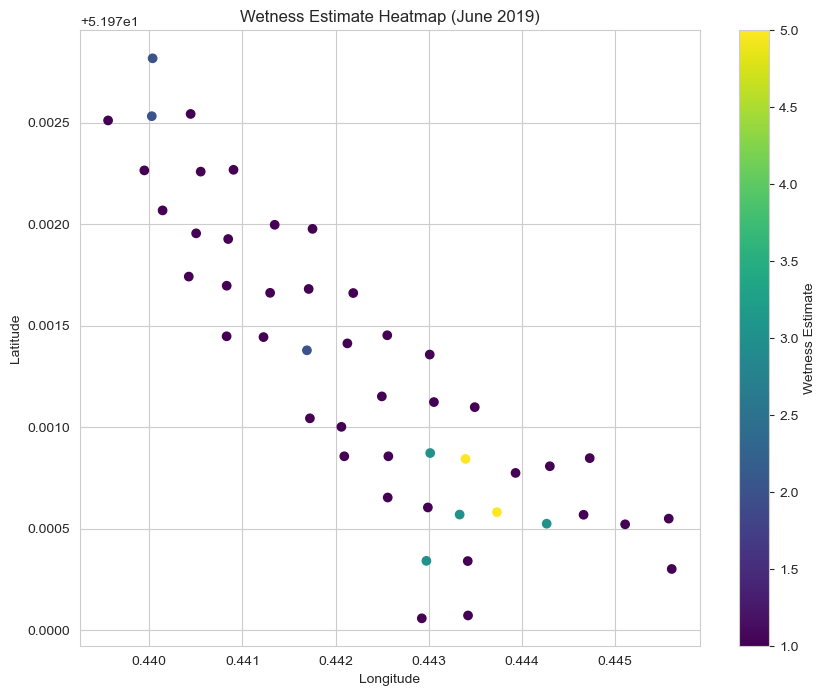

In [20]:
plt.figure(figsize=(10, 8))
scatter = plt.scatter(x=df_june_2019['lon'], y=df_june_2019['lat'], c=df_june_2019['wetness_estimate'], cmap='viridis')
plt.colorbar(scatter, label='Wetness Estimate')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Wetness Estimate Heatmap (June 2019)')
plt.show()

In [29]:
import folium
import pandas as pd
import ipywidgets as widgets
from IPython.display import display

# Assuming your DataFrame is named 'df'

# Convert 'date' to datetime and extract year
df['date'] = pd.to_datetime(df['date'])
df['year'] = df['date'].dt.year

# Group data by year
yearly_data = {year: group for year, group in df.groupby('year')}

# Create the base map
m = folium.Map(location=[df['lat'].mean(), df['lon'].mean()], zoom_start=15)

# Function to update the map layer
def update_map(year):
    year_data = yearly_data.get(year)
    if year_data is not None:
        # Clear existing layers
        for layer in m._children.values():
            if isinstance(layer, folium.CircleMarker):
                m.remove_child(layer)

        # Add CircleMarkers with colors based on wetness
        for index, row in year_data.iterrows():
            lat, lon, wetness = row['lat'], row['lon'], row['wetness_estimate']

            # Adjust color scale as needed
            color = 'green' if wetness > 4 else 'yellow' if wetness > 1.5 else 'red'

            folium.CircleMarker(
                location=[lat, lon],
                radius=5,  # Adjust radius as needed
                color=color,
                fill=True,
                fill_color=color,
                fill_opacity=0.6,
                tooltip=f"Wetness: {wetness}",
            ).add_to(m)

# Create the slider
years = sorted(list(yearly_data.keys()))
year_slider = widgets.IntSlider(min=min(years), max=max(years), step=1, value=min(years))

# Link the slider to the update function
def on_year_change(change):
    update_map(change.new)

year_slider.observe(on_year_change, names='value')

# Initialize the map with the first year
update_map(year_slider.value)

# Display the map and slider
display(year_slider)
display(m)

IntSlider(value=2019, max=2024, min=2019)